In [1]:
import collections
import hashlib
import itertools
import json
import sys
from copy import deepcopy
from pathlib import Path
from time import time
from math import comb
from functools import reduce
from omegaconf import DictConfig

import bokeh
import hiplot as hip
import matplotlib
import numpy as np
import pandas as pd
import pandas_bokeh
import ray
from bson.objectid import ObjectId
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from pymongo import MongoClient
from math import comb
from functools import reduce
import seaborn as sns

import xplogger

print(xplogger.__version__)
from xplogger.experiment_manager.record.record_list import RecordList
from xplogger.experiment_manager.store.mongo import MongoStore
from xplogger.experiment_manager.viz import bokeh as bokeh_viz
from xplogger.experiment_manager.notebook import utils as notebook_utils
from xplogger.parser.experiment import (
    Experiment,
    ExperimentSequence,
    ExperimentSequenceDict,
)
from xplogger.parser.experiment import utils as experiment_utils

sys.path.append("/private/home/sodhani/projects/abstraction_by_gating/")

from math import sqrt
from time import time

from IPython.display import JSON
from notebooks import utils, ds

0.10.0


In [2]:
%matplotlib inline
pd.set_option("plotting.backend", "pandas_bokeh")
pandas_bokeh.output_notebook()

%matplotlib inline
sns.color_palette("deep")

plt.rc("axes", titlesize=18)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=13)  # fontsize of the tick labels
plt.rc("ytick", labelsize=13)  # fontsize of the tick labels
plt.rc("legend", fontsize=13)  # legend fontsize
plt.rc("font", size=13)  # controls default text sizes

Loading BokehJS ...

In [3]:
collection_name = "abstraction_by_gating"

use_record_ids = False
ray.init(num_cpus=20, ignore_reinit_error=True)

E0605 15:15:21.533569257 2240829 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0605 15:15:21.569970833 2240829 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0605 15:15:21.594440243 2240829 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


{'node_ip_address': '100.97.66.230',
 'raylet_ip_address': '100.97.66.230',
 'redis_address': '100.97.66.230:47828',
 'object_store_address': '/tmp/ray/session_2022-06-05_15-15-20_359853_2240829/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-06-05_15-15-20_359853_2240829/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-06-05_15-15-20_359853_2240829',
 'metrics_export_port': 64831,
 'gcs_address': '100.97.66.230:34851',
 'node_id': '24a80ecf1110f60b4f1ee3e481f282bfbe46920fb1f9f6b8cf472dc7'}

In [4]:
mongo_store = MongoStore(
    config={
        "host": "localhost",
        "port": 27017,
        "db": "project",
        "collection_name": collection_name,
    }
)
print(f"Num documents: {mongo_store.collection.count_documents({})}")

Num documents: 43900


In [5]:
start_time = time()
mongo_records = mongo_store.get_records(query={})
print(time() - start_time)

5.113709449768066


In [6]:
mongo_to_record = {}
issue_to_mongo_record = {}
unanalyzed_records = []
start = time()
for record in mongo_records:
    mongo_record_id = record.id
    mongo_to_record[mongo_record_id] = record
    issue_id = str(record["setup"]["git"]["issue_id"])
    if issue_id not in issue_to_mongo_record:
        issue_to_mongo_record[issue_id] = []
    issue_to_mongo_record[issue_id].append(record)
    if record["status"] != "ANALYZED":
        unanalyzed_records.append(record)

print(f"Time taken: {time() - start}")
assert len(unanalyzed_records) == len(mongo_store.get_unanalyzed_records())

Time taken: 0.18085360527038574


In [7]:
start = time()
record_list = RecordList(unanalyzed_records[:])
print(f"Total number of unanalayzed records: {len(record_list)}")
unique_issues = record_list.get_unique_issues()
print(unique_issues)
print(f"Time taken: {time() - start}")

Total number of unanalayzed records: 32475
Counter({'1': 15942, '3': 4809, '25': 2751, '4': 2304, '36': 1408, '28': 1152, '29': 1123, '22': 962, '35': 614, '3-1': 480, '121': 372, 'dummy': 220, '31': 168, '18': 158, '30': 12})
Time taken: 0.06200265884399414


In [8]:
record_list = []
for issue_id in ["32"]:
    record_list += issue_to_mongo_record[issue_id]


def key_func(record):
    return record["setup"]["id"]


def filter_fn(record):
    return True


print(len(record_list))
record_list = RecordList([x for x in record_list if filter_fn(x)])
# RecordList([x for x in record_list.ray_make_oc_records() if x["status"]!="ANALYZED" and "id" in x]).mark_analyzed(collection=mongo_store.collection)
slurm_id_to_record_map = record_list.map_to_slurm_id()
record_list = record_list.get_unique(key_func).ray_make_oc_records()
# print(f"Time taken: {time() - start}")
print(f"Number of selected records: {len(record_list)}")
print(
    f"Number of uniques runs: {len(set(record['setup']['id'] for record in record_list))}"
)
print(
    f"Number of unanalyzed runs: {len(set(record['setup']['id'] for record in record_list if record['status']!='ANALYZED'))}"
)
print(
    f"Set of issues: {set(record['setup']['git']['issue_id'] for record in record_list)}"
)
print(
    f"Set of script ids: {set(record['setup']['script_id'] for record in record_list)}"
)

211
Number of selected records: 211
Number of uniques runs: 211
Number of unanalyzed runs: 0
Set of issues: {32}
Set of script ids: {32, '32-1'}


In [9]:
record_list = RecordList(list(x for x in record_list if x.setup.script_id in [32, "32-1"]))
print(len(record_list))

211


In [10]:
# record_list.delete(collection=mongo_store.collection, delete_from_filesystem=False)
# record_list.mark_analyzed(collection=mongo_store.collection)

In [11]:
load_experiment_from_dir = lambda log_dir: utils.load_experiment_from_dir(
    log_dir=log_dir,
    cache_failed_experiment=True,
    verbose=False,
    skip_cache=False,
)

viz_params = record_list.get_viz_params()

viz_params.remove("experiment")
start_time = time()

(
    exp_seq_dict,
    groups,
    hyperparams,
) = record_list.make_experiment_sequence_dict_groups_and_hyperparams(
    viz_params, load_experiment_from_dir
)

print(f"Time taken: {time() - start_time}")


notebook_utils.prettyprint_dict(hyperparams)

Time taken: 3.9789249897003174
experiment.task.num_classes_in_selected_dataset
	{10}
model.non_linearity_cfg.negative_slope
	{0.1, 0.9, 0.8, 1.2, 0.01}
setup.script_id
	{32, '32-1'}
model.pretrained_cfg.should_use
	{False}
model.decoder_cfg.should_share
	{False}
experiment.num_epochs
	{1000}
model.gate_cfg.mode
	{'30_plus_mod_permute', '35_plus_mod_permute', '20_plus_mod_permute', '25_plus_mod_permute', '10_plus_mod_permute', '15_plus_mod_permute', '5_plus_mod_permute'}
model.weight_init.bias
	{0}
experiment.task.mode
	{'permute_input_permute_target', 'rotate_input_permute_target'}
optimizer.lr
	{0.0001}
model.non_linearity_cfg._target_
	{'torch.nn.LeakyReLU'}
model.hidden_layer_cfg.dim
	{128}
optimizer.momentum
	{0.9}
model.weight_init.gain
	{0.1, 1.0, 10.0, 0.01, 0.0001, 0.001}
model.weight_init.should_do
	{True}
dataloader.name
	{'mnist'}
model.num_layers
	{1}
model.hidden_layer_cfg.should_use_non_linearity
	{True}
model.hidden_layer_cfg.num_layers
	{2}
model.encoder_cfg.should_shar

In [12]:
viz_params

{'dataloader.name',
 'dataloader.train_config.dataloader.batch_size',
 'experiment.num_epochs',
 'experiment.task.mode',
 'experiment.task.num_classes_in_selected_dataset',
 'experiment.task.num_input_transformations',
 'model.decoder_cfg.should_share',
 'model.encoder_cfg.should_share',
 'model.gate_cfg.mode',
 'model.hidden_layer_cfg.dim',
 'model.hidden_layer_cfg.num_layers',
 'model.hidden_layer_cfg.should_share',
 'model.hidden_layer_cfg.should_use_non_linearity',
 'model.non_linearity_cfg._target_',
 'model.non_linearity_cfg.negative_slope',
 'model.num_layers',
 'model.pretrained_cfg.should_use',
 'model.should_use_non_linearity',
 'model.weight_init.bias',
 'model.weight_init.gain',
 'model.weight_init.should_do',
 'optimizer._target_',
 'optimizer.lr',
 'optimizer.momentum',
 'setup.script_id'}

In [13]:
print(list(exp_seq_dict.values())[0])
print(type(list(exp_seq_dict.values())[0]))

<class 'xplogger.parser.experiment.experiment.ExperimentSequence'>


In [14]:
exp = list(exp_seq_dict.values())[0][0]
pd.options.display.max_columns = None
pd.options.display.max_rows = None
exp.metrics["train_epoch"]

,average_loss_for_selected_paths,average_loss_for_unselected_paths,average_accuracy_for_selected_paths,average_accuracy_for_unselected_paths,gating_matrix,epoch,mode,step,time_taken,logbook_id,logbook_timestamp,logbook_type
0,155.674286,445.051666,0.466779,0.105170,0,0,train,7499,191.101240,0,"04:28:14PM UTC Feb 12, 2022",metric
2,14.744773,88.548584,0.522247,0.112281,0,1,train,14999,178.015558,0,"04:31:29PM UTC Feb 12, 2022",metric
4,4.829724,29.017199,0.492595,0.111544,0,2,train,22499,177.711565,0,"04:34:45PM UTC Feb 12, 2022",metric
6,3.152763,17.704903,0.492896,0.111182,0,3,train,29999,179.550801,0,"04:38:02PM UTC Feb 12, 2022",metric
8,2.573825,14.012965,0.504961,0.111384,0,4,train,37499,180.456012,0,"04:41:20PM UTC Feb 12, 2022",metric
10,2.254009,12.187248,0.519580,0.111727,0,5,train,44999,181.919137,0,"04:44:41PM UTC Feb 12, 2022",metric
12,2.038531,11.048344,0.534242,0.112128,0,6,train,52499,181.679147,0,"04:48:00PM UTC Feb 12, 2022",metric
14,1.879924,10.257577,0.547801,0.112569,0,7,train,59999,182.223250,0,"04:51:21PM UTC Feb 12, 2022",metric
16,1.757544,9.664641,0.560430,0.112976,0,8,train,67499,177.704659,0,"04:54:37PM UTC Feb 12, 2022",metric
18,1.658385,9.204641,0.572055,0.113389,0,9,train,74999,181.344537,0,"04:57:56PM UTC Feb 12, 2022",metric


In [15]:
list(exp_seq_dict.values())[0][0].config["setup"]["viz"]

{'params': ['experiment.num_epochs',
  'experiment.task.num_input_transformations',
  'experiment.task.num_classes_in_selected_dataset',
  'dataloader.train_config.dataloader.batch_size',
  'dataloader.name',
  'experiment',
  'model.num_layers',
  'model.gate_cfg.mode',
  'model.pretrained_cfg.should_use',
  'experiment.task.mode',
  'model.hidden_layer_cfg.dim',
  'model.should_use_non_linearity',
  'model.encoder_cfg.should_share',
  'model.hidden_layer_cfg.should_share',
  'model.decoder_cfg.should_share',
  'setup.script_id',
  'model.weight_init.should_do',
  'model.weight_init.gain',
  'model.weight_init.bias',
  'optimizer._target_',
  'optimizer.lr',
  'optimizer.momentum',
  'model.hidden_layer_cfg.should_use_non_linearity',
  'model.hidden_layer_cfg.num_layers',
  'model.non_linearity_cfg._target_',
  'model.non_linearity_cfg.negative_slope']}

In [16]:
notebook_utils.prettyprint_dict(hyperparams)

experiment.task.num_classes_in_selected_dataset
	{10}
model.non_linearity_cfg.negative_slope
	{0.1, 0.9, 0.8, 1.2, 0.01}
setup.script_id
	{32, '32-1'}
model.pretrained_cfg.should_use
	{False}
model.decoder_cfg.should_share
	{False}
experiment.num_epochs
	{1000}
model.gate_cfg.mode
	{'30_plus_mod_permute', '35_plus_mod_permute', '20_plus_mod_permute', '25_plus_mod_permute', '10_plus_mod_permute', '15_plus_mod_permute', '5_plus_mod_permute'}
model.weight_init.bias
	{0}
experiment.task.mode
	{'permute_input_permute_target', 'rotate_input_permute_target'}
optimizer.lr
	{0.0001}
model.non_linearity_cfg._target_
	{'torch.nn.LeakyReLU'}
model.hidden_layer_cfg.dim
	{128}
optimizer.momentum
	{0.9}
model.weight_init.gain
	{0.1, 1.0, 10.0, 0.01, 0.0001, 0.001}
model.weight_init.should_do
	{True}
dataloader.name
	{'mnist'}
model.num_layers
	{1}
model.hidden_layer_cfg.should_use_non_linearity
	{True}
model.hidden_layer_cfg.num_layers
	{2}
model.encoder_cfg.should_share
	{False}
dataloader.train_con

In [17]:
type(list(exp_seq_dict.values())[0])

xplogger.parser.experiment.experiment.ExperimentSequence

In [18]:
y_metric_list = ["average_accuracy_for_selected_paths"]
x_metric = "epoch"
mode = "test_epoch"


def filter_fn(key, experiment_sequence):
    def filter_experiment(exp):
        if not exp:
            return False
        model_cfg = exp.config["model"]
        return (
            exp.config["experiment"]["task"]["mode"] == "rotate_input_permute_target"
            and model_cfg["hidden_layer_cfg"]["dim"] == 128
            and model_cfg["num_layers"] == 1
            and model_cfg["weight_init"]["bias"] == 0
            and model_cfg["weight_init"]["gain"] in [10.0,1.0,0.1]
            and exp.config["optimizer"]["_target_"] == "torch.optim.SGD"
            #             and model_cfg["weight_init"]["gain"] == 0.001
            #             and model_cfg["gate_cfg"]["mode"] in ["4_plus_mod_permute", "4_plus_mod"]
            and model_cfg["gate_cfg"]["mode"]
            in ["10_plus_mod_permute"]
#             in ["4_plus_mod", "4_plus_mod_permute", "6_plus_mod", "6_plus_mod_permute"]
            and exp.config["experiment"]["task"]["num_classes_in_selected_dataset"] == 10
            and exp.config["model"]["hidden_layer_cfg"]["should_use_non_linearity"] == True
        )

    return all(filter_experiment(exp) for exp in experiment_sequence)


def get_function_to_get_experiment_name(param_list: list[DictConfig]):
    unique_params_and_values = {}
    words_to_ignore = []
    for param in param_list:
        for key, value in param.items():
            if key not in unique_params_and_values:
                unique_params_and_values[key] = set()
            unique_params_and_values[key].add(value)
    for key, value in unique_params_and_values.items():
        if len(value) == 1:
            words_to_ignore.append(key)

    def get_experiment_name(params, **kwargs):
        return "-".join(
            [
                f"{val}"
                for key, val in sorted(
                    list((OmegaConf.to_container(params)).items())
                    + list(kwargs.items())
                )
                if all(word not in key for word in words_to_ignore)
            ]
        )
        return "-".join(
            [
                f"{val}"
                for key, val in sorted(
                    list((OmegaConf.to_container(params)).items())
                    + list(kwargs.items())
                )
                if all(word not in key for word in words_to_ignore)
            ]
        )

    return get_experiment_name

def plot(
    filter_fn,
    y_metric_list: list[str] = ["return_mean"],
    x_metric: str = "frames",
    mode: str = "train",
    metadata_for_plot={},
    p=None,
    color_palette=None,
    color_offset: int = 0,
    colors=None,
):

    filtered_exp_seq_dict = ExperimentSequenceDict(
        {
            key: ExperimentSequence(experiment_sequence)
            for key, experiment_sequence in sorted(
                exp_seq_dict.items(),
                key=lambda item: sorted(OmegaConf.to_container(item[0]).items()),
            )
            if filter_fn(key, experiment_sequence)
        }
    )

    fn_to_get_experiment_name = get_function_to_get_experiment_name(
        param_list=list(filtered_exp_seq_dict.keys())
    )

    color_palette = bokeh.palettes.d3["Category20"]

    return bokeh_viz.plot_experiment_sequence_dict(
        exp_seq_dict=filtered_exp_seq_dict,
        kwargs_for_aggregate_metrics = {
            "get_experiment_name": fn_to_get_experiment_name,
            "x_name": x_metric,
            "mode": mode,
            "drop_duplicates": True,
            "dropna": True,
            "verbose": True,
            "metric_names": y_metric_list,
            "x_min": 100,
            "x_max": 1000,
        },
        metadata_for_plot=metadata_for_plot,
        color_palette=color_palette,
        p=p,
        colors=colors,
        color_offset=color_offset,
    )
        

title = "title"
color_palette = bokeh.palettes.d3["Category20"]
colors = color_palette[20][::1]

p = None

p = plot(
    filter_fn=filter_fn,
    metadata_for_plot={"title": title, "fill_alpha": 0.2},
    y_metric_list=y_metric_list,
    x_metric=x_metric,
    color_palette=color_palette,
    mode=mode,
    p=p,
    color_offset=0,
    colors=colors,
)

p.legend.click_policy = "hide"
# p.legend.visible=


bokeh.plotting.show(p)

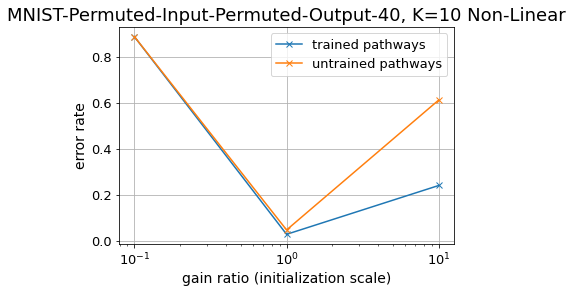

In [19]:
x = np.asarray([0.1, 1.0, 10.0])

K = 10
#permute input
data_y = {
    10: {
#         "trained": np.asarray([91.4, 92.4, 88.1]),
#         "untrained": np.asarray([91.3, 65, 37.6]),
#         "trained": np.asarray([11.3, 92.4, 87.6]),
#         "untrained": np.asarray([11.3, 81.2, 43.8]),
#         "trained": np.asarray([11.3, 92.4, 87.7]),
#         "untrained": np.asarray([11.3, 84.1, 44.2]),
#         "trained": np.asarray([11.3, 97.3, 77.6]),
#         "untrained": np.asarray([11.3, 96.9, 55.7]),
        "trained": np.asarray([11.3, 97.1, 75.9]),
        "untrained": np.asarray([11.3, 95.2, 38.8]),
    }
}

# rotate input
# data_y = {
#     10: {
#         "trained": np.asarray([91.2, 92.4, 88.1]),
#         "untrained": np.asarray([84.1, 70.3, 38.8]),
#     }
# }

for mode in ["trained", "untrained"]:
    plt.plot(x, (100 - data_y[K][mode]) / 100, label = f"{mode} pathways", marker = "x")
    
plt.ylabel("error rate")
plt.xscale('log')
plt.xlabel("gain ratio (initialization scale)")

plt.title(f"MNIST-Permuted-Input-Permuted-Output-40, K={K} Non-Linear")
plt.grid()
plt.legend()

# plt.show()

# plt.savefig(
#     f"/private/home/sodhani/projects/abstraction_by_gating/results/mnist-permute-input-40-gain-ratio-{K}-percent-128.pdf",
#     dpi=300,
#     bbox_inches="tight",
# )
# plt.clf()

In [20]:
def map_combination_to_hyperparams(combination):
    combination_dict = {}
    for key, value in zip(hyperparams.keys(), combination):
        combination_dict[key] = value
    return combination_dict

In [21]:
def make_metadata(
    mode: str,
    max_epochs: int,
    min_epochs: int,
    metric_name: str,
):
    metadata = OmegaConf.create(
        {
            "metric_name": metric_name,
            "mode": mode,
            "x": {"name": "epoch", "min": min_epochs, "max": max_epochs},
        }
    )

    step_metadata = OmegaConf.create(
        {
            "metric_name": "epoch",
            "mode": mode,
            "x": {"name": "epoch", "min": min_epochs, "max": max_epochs},
        }
    )

    return metadata, step_metadata

In [22]:
type(list(exp_seq_dict.values())[0])

xplogger.parser.experiment.experiment.ExperimentSequence

In [23]:
mode = "test_epoch"
# metric_name = "accuracy_task_two_encoder_task_one_decoder"

metrics = [
    "average_accuracy_for_selected_paths",
    "average_accuracy_for_unselected_paths",
    "average_loss_for_selected_paths",
    "average_loss_for_unselected_paths",
]

df_dict = {}

for metric_name in metrics:
    metadata, step_metadata = make_metadata(
        mode=mode,
        max_epochs=1000,
        min_epochs=1,
        metric_name=metric_name,
    )

    df_dict[metric_name] = notebook_utils.make_df(
        metadata=metadata,
        step_metadata=step_metadata,
        groups=groups,
        hyperparams=hyperparams,
        exp_seq_dict=exp_seq_dict,
    )
    
#     df_dict[key].drop(
#         [],
#         axis=1,
#         inplace=True,
#     )

In [24]:
df_dict["average_accuracy_for_unselected_paths"]

,experiment.task.num_classes_in_selected_dataset,model.non_linearity_cfg.negative_slope,setup.script_id,model.pretrained_cfg.should_use,model.decoder_cfg.should_share,experiment.num_epochs,model.gate_cfg.mode,model.weight_init.bias,experiment.task.mode,optimizer.lr,model.non_linearity_cfg._target_,model.hidden_layer_cfg.dim,optimizer.momentum,model.weight_init.gain,model.weight_init.should_do,dataloader.name,model.num_layers,model.hidden_layer_cfg.should_use_non_linearity,model.hidden_layer_cfg.num_layers,model.encoder_cfg.should_share,dataloader.train_config.dataloader.batch_size,optimizer._target_,model.should_use_non_linearity,model.hidden_layer_cfg.should_share,experiment.task.num_input_transformations,mean_average_accuracy_for_unselected_paths,stderr_average_accuracy_for_unselected_paths,steps,seeds
0,10,0.10,32,False,False,1000,30_plus_mod_permute,0,permute_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,0.1000,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.113500,0.0,1000.0,1
1,10,0.10,32,False,False,1000,30_plus_mod_permute,0,permute_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,1.0000,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.973276,0.0,1000.0,1
2,10,0.10,32,False,False,1000,30_plus_mod_permute,0,permute_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,10.0000,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.879673,0.0,1000.0,1
3,10,0.10,32,False,False,1000,30_plus_mod_permute,0,permute_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,0.0100,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.113500,0.0,1000.0,1
4,10,0.10,32,False,False,1000,30_plus_mod_permute,0,permute_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,0.0001,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.113500,0.0,1000.0,1
5,10,0.10,32,False,False,1000,30_plus_mod_permute,0,permute_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,0.0010,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.113500,0.0,1000.0,1
6,10,0.10,32,False,False,1000,30_plus_mod_permute,0,rotate_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,0.1000,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.113500,0.0,1000.0,1
7,10,0.10,32,False,False,1000,30_plus_mod_permute,0,rotate_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,1.0000,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.972526,0.0,1000.0,1
8,10,0.10,32,False,False,1000,30_plus_mod_permute,0,rotate_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,10.0000,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.882667,0.0,1000.0,1
9,10,0.10,32,False,False,1000,30_plus_mod_permute,0,rotate_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,0.0100,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.113500,0.0,1000.0,1


In [25]:
keys_to_merge_on = [
    "model.hidden_layer_cfg.dim",
    "experiment.task.num_classes_in_selected_dataset",
    "experiment.num_epochs",
    "dataloader.name",
    "model.decoder_cfg.should_share",
    "model.weight_init.bias",
    "experiment.task.mode",
    "model.num_layers",
    "optimizer._target_",
    "setup.script_id",
    "model.weight_init.gain",
    "model.weight_init.should_do",
    "model.encoder_cfg.should_share",
    "experiment.task.num_input_transformations",
    "optimizer.lr",
    "optimizer.momentum",
    "model.should_use_non_linearity",
    "model.gate_cfg.mode",
    "dataloader.train_config.dataloader.batch_size",
    "model.pretrained_cfg.should_use",
    "model.hidden_layer_cfg.should_share",
    "steps",
    "seeds",
    "model.hidden_layer_cfg.num_layers",
    "model.hidden_layer_cfg.should_use_non_linearity",
    "model.non_linearity_cfg.negative_slope",
    "model.non_linearity_cfg._target_",
]
merged_df = df_dict[metrics[0]]
for current_metric in metrics[1:]:
    merged_df = merged_df.merge(
        df_dict[current_metric], on=keys_to_merge_on, suffixes=[None, None]
    )

merged_df = merged_df.drop(
    [
        "seeds",
        "steps",
        "experiment.num_epochs",
        "mean_average_loss_for_unselected_paths",
        "mean_average_loss_for_selected_paths",
    ]
    + [f"stderr_{metric_name}" for metric_name in metrics],
    axis=1,
)

merged_df.style.set_sticky(axis="columns")

merged_df

# import seaborn as sns

# cm = sns.light_palette("red", as_cmap=True)

# merged_df.style.background_gradient(
#     axis=1, subset=[f"mean_return_mean_{key}" for key in keys], vmax=1.4, vmin=0.6
# )

,experiment.task.num_classes_in_selected_dataset,model.non_linearity_cfg.negative_slope,setup.script_id,model.pretrained_cfg.should_use,model.decoder_cfg.should_share,model.gate_cfg.mode,model.weight_init.bias,experiment.task.mode,optimizer.lr,model.non_linearity_cfg._target_,model.hidden_layer_cfg.dim,optimizer.momentum,model.weight_init.gain,model.weight_init.should_do,dataloader.name,model.num_layers,model.hidden_layer_cfg.should_use_non_linearity,model.hidden_layer_cfg.num_layers,model.encoder_cfg.should_share,dataloader.train_config.dataloader.batch_size,optimizer._target_,model.should_use_non_linearity,model.hidden_layer_cfg.should_share,experiment.task.num_input_transformations,mean_average_accuracy_for_selected_paths,mean_average_accuracy_for_unselected_paths
0,10,0.10,32,False,False,30_plus_mod_permute,0,permute_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,0.1000,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.113500,0.113500
1,10,0.10,32,False,False,30_plus_mod_permute,0,permute_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,1.0000,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.973282,0.973276
2,10,0.10,32,False,False,30_plus_mod_permute,0,permute_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,10.0000,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.881484,0.879673
3,10,0.10,32,False,False,30_plus_mod_permute,0,permute_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,0.0100,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.113500,0.113500
4,10,0.10,32,False,False,30_plus_mod_permute,0,permute_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,0.0001,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.113500,0.113500
5,10,0.10,32,False,False,30_plus_mod_permute,0,permute_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,0.0010,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.113500,0.113500
6,10,0.10,32,False,False,30_plus_mod_permute,0,rotate_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,0.1000,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.113500,0.113500
7,10,0.10,32,False,False,30_plus_mod_permute,0,rotate_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,1.0000,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.972562,0.972526
8,10,0.10,32,False,False,30_plus_mod_permute,0,rotate_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,10.0000,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.884254,0.882667
9,10,0.10,32,False,False,30_plus_mod_permute,0,rotate_input_permute_target,0.0001,torch.nn.LeakyReLU,128,0.9,0.0100,True,mnist,1,True,2,False,8,torch.optim.SGD,False,True,40,0.113500,0.113500


In [26]:
df_to_plot = merged_df

hip.Experiment.from_dataframe(df_to_plot).display()

<IPython.core.display.Javascript object>

{12.5: 0.9686252474784851, 25.0: 0.9715302586555481, 37.5: 0.9730271100997925, 50.0: 0.9735303521156311, 62.5: 0.9734863042831421, 75.0: 0.9734389185905457, 87.5: 0.9733343720436096}
{12.5: 0.4367682933807373, 25.0: 0.9519776105880737, 37.5: 0.9729650020599365, 50.0: 0.9735116958618164, 62.5: 0.9734597206115723, 75.0: 0.9734151363372803, 87.5: 0.9733197093009949}


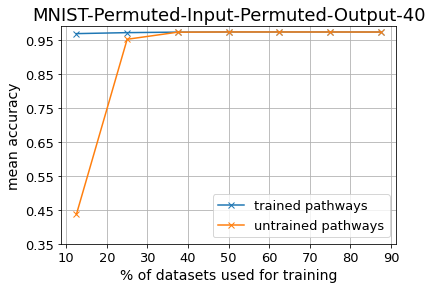

In [27]:
num_classes_in_selected_dataset = 10
dim = 128
optimizer_lr = 0.0001
# experiment_task_mode = "rotate_input_permute_target"
experiment_task_mode = "permute_input_permute_target"
leaky_relu_negative_slope = 0.01
# "model.non_linearity_cfg.negative_slope",
#     "model.non_linearity_cfg._target_",
num_input_transformations = 40
should_use_non_linearity = True


def get_filters(df):
    filters = {
        "experiment.task.num_classes_in_selected_dataset": num_classes_in_selected_dataset,
        "experiment.task.mode": experiment_task_mode,
        "optimizer.lr": optimizer_lr,
        "model.hidden_layer_cfg.dim": dim,
        "experiment.task.num_input_transformations": num_input_transformations,
        "model.hidden_layer_cfg.should_use_non_linearity": should_use_non_linearity,
        "model.non_linearity_cfg._target_": "torch.nn.LeakyReLU",
        "model.non_linearity_cfg.negative_slope": leaky_relu_negative_slope,
    }
    return reduce(
        lambda x, y: x & y, [df[key] == val for key, val in filters.items()], True
    )


df = df_to_plot[get_filters(df_to_plot)]

x_metric_name = "model.gate_cfg.mode"

for y_metric_name in ["mean_average_accuracy_for_selected_paths", "mean_average_accuracy_for_unselected_paths"]:

    points = []
    for x, y in zip(df[x_metric_name], df[y_metric_name]):
        x = ds.make_transformed_x(x)
        points.append(ds.Point(x, y))

    points.sort()

    x_y = {}
    # x, y = [], []
    for p in points:
        x = float(p.x.normalize(num_input_transformations=num_input_transformations))
        if x not in x_y:
            x_y[x] = y
        else:
            x_y[x] = max(x_y[x], p.y)

    print(x_y)
    # plt.plot(x, y)
    if y_metric_name == "mean_average_accuracy_for_unselected_paths":
        label = "untrained pathways"
    else:
        label = "trained pathways"
    plt.plot(x_y.keys(), x_y.values(), label=label, marker = "x")
    # print(x)
    # print(y)

if num_input_transformations == 100:
    plt.title(r'MNIST-Permuted-Input-Permuted-Output-100')
elif experiment_task_mode == "rotate_input_permute_target":
    plt.title(f'MNIST-Rotated-Input-Permuted-Output-40')
#     plt.title(f'MNIST-Rotated-Input-Permuted-Output-40-negative-slope-{leaky_relu_negative_slope}')
elif experiment_task_mode == "permute_input_permute_target":
    plt.title(r'MNIST-Permuted-Input-Permuted-Output-40')
    
plt.xlabel("% of datasets used for training")
# plt.ylabel(" ".join(y_metric_name.split("_")[:3]))
plt.ylabel("mean accuracy")

lower_range = 0.35
upper_range = 0.99

plt.yticks(np.arange(lower_range, upper_range, 0.1))
plt.xticks(np.arange(10, 100, 10))
plt.ylim([lower_range, upper_range])

plt.legend(loc="lower right")
plt.grid()

path = f"/private/home/sodhani/projects/abstraction_by_gating/results/mnist-{experiment_task_mode.replace('_', '-')}-{num_input_transformations}-leakly-relu-0.01-line_{dim}.pdf"
# print(path)

# plt.show()

# plt.savefig(
#     path,
#     dpi=300,
#     bbox_inches="tight",
# )
# plt.clf()


In [28]:
from __future__ import annotations

import math
from typing import Any, Optional

from bokeh.plotting import figure

from xplogger.parser.experiment import ExperimentSequenceDict  # type: ignore


# y_metric_list = ["accuracy_odd_even", "accuracy_greater_than_four"]
y_metric_list = ["average_accuracy_for_selected_paths"]
# y_metric_list = ["accuracy"]
x_metric = "epoch"
mode = "test_epoch"


def filter_fn(key, experiment_sequence):
    def filter_experiment(exp):
        if not exp:
            return False
        model_cfg = exp.config["model"]
        return (
            exp.config["experiment"]["task"]["mode"] == "permute_input_permute_target"
            and model_cfg["hidden_layer_cfg"]["dim"] == 128
            and model_cfg["num_layers"] == 1
            and model_cfg["weight_init"]["bias"] == 0
#             and model_cfg["weight_init"]["gain"] not in [0.0001, 0.001, 0.01]
            and exp.config["optimizer"]["_target_"] == "torch.optim.SGD"
            #             and model_cfg["weight_init"]["gain"] == 0.001
            #             and model_cfg["gate_cfg"]["mode"] in ["4_plus_mod_permute", "4_plus_mod"]
            and model_cfg["gate_cfg"]["mode"]
            in ["90_plus_mod_permute"]
#             in ["4_plus_mod", "4_plus_mod_permute", "6_plus_mod", "6_plus_mod_permute"]
            and exp.config["experiment"]["task"]["num_classes_in_selected_dataset"] == 10
        )

    return all(filter_experiment(exp) for exp in experiment_sequence)


def get_function_to_get_experiment_name(param_list: list[DictConfig]):
    unique_params_and_values = {}
    words_to_ignore = []
    for param in param_list:
        for key, value in param.items():
            if key not in unique_params_and_values:
                unique_params_and_values[key] = set()
            unique_params_and_values[key].add(value)
    for key, value in unique_params_and_values.items():
        if len(value) == 1:
            words_to_ignore.append(key)

    def get_experiment_name(params, **kwargs):
        return params["model.weight_init.gain"]
    return get_experiment_name


In [29]:



def matplotlib_plot_experiment_sequence_dict(
    exp_seq_dict: ExperimentSequenceDict,
    metadata_for_plot: dict[str, Any],
    color_palette: list[Any],
    plt: Optional[figure],
    colors: Optional[list[str]] = None,
    color_offset: int = 0,
    return_all_metrics_with_same_length: bool = True,
    kwargs_for_aggregate_metrics: Optional[dict[str, Any]] = None,
) -> figure:
    """Plot the given experiment sequence dict as a matplotlib.

    Args:
        exp_seq_dict (ExperimentSequenceDict):
        metadata_for_plot (dict[str, Any]):
        color_palette (list[Any]):
        p (Optional[figure]):
        colors (Optional[list[str]], optional): Defaults to None.
        color_offset (int, optional): Defaults to 0.
        kwargs_for_aggregate_metrics (Optional[dict[str, Any]], optional):
            These arguments are pass to aggregation function of exp_seq_dict.
            Defaults to None.

    Returns:
        figure:
    """
    if not kwargs_for_aggregate_metrics:
        kwargs_for_aggregate_metrics = {}

    for key in [
        "get_experiment_name",
        "metric_names",
        "x_name",
        "x_min",
        "x_max",
        "mode",
        "drop_duplicates",
        "dropna",
        "verbose",
    ]:
        assert key in kwargs_for_aggregate_metrics

    x_metric = kwargs_for_aggregate_metrics["x_name"]
    y_metric_list = kwargs_for_aggregate_metrics["metric_names"]

    
    

    data = exp_seq_dict.aggregate_metrics(
        return_all_metrics_with_same_length=return_all_metrics_with_same_length,
        **kwargs_for_aggregate_metrics,
    )

    if colors is None:
        try:
            colors = color_palette[len(data) + color_offset]
        except KeyError:
            # this could be because we have fewer data points than 3
            colors = color_palette[3][: len(data) + color_offset]
    assert colors is not None
    for index, (key, y) in enumerate(data.items(), color_offset):
        if key.endswith(f"_{x_metric}"):
            continue
        for current_metric_name in y_metric_list:
            if key.endswith(current_metric_name):
                current_exp_seq_key = key.replace(f"_{current_metric_name}", "")
                break
        else:
            print("Can not find the metric name.")
            breakpoint()
        x_key = f"{current_exp_seq_key}_{x_metric}"
        x = data[x_key].mean(axis=0)[::20]
        mean = y.mean(axis=0)[::20]
        stderr = y.std(axis=0) / math.sqrt(len(y))
        gain, mode = key.split("_", 1)
        if mode == "average_accuracy_for_unselected_paths":
            marker = "x"
            label = "untrained"
        else:
            marker = "."
            label = "trained"
        label = f"{label}, gain={gain}"
        print(key, mode)
        plt.plot(x, mean, linewidth=2, color=colors[index], label=label, marker=marker)
        # p.varea(
        #     x,
        #     mean - stderr,
        #     mean + stderr,
        #     fill_alpha=metadata_for_plot.get("fill_alpha", 0.6),
        #     color=colors[index],
        # )

    # p.legend.location = "bottom_right"
    # p.legend.click_policy = "hide"
    # return p

    
def plot(
    filter_fn,
    y_metric_list: list[str] = ["return_mean"],
    x_metric: str = "frames",
    mode: str = "train",
    metadata_for_plot={},
    p=None,
    color_palette=None,
    color_offset: int = 0,
    colors=None,
):

    filtered_exp_seq_dict = ExperimentSequenceDict(
        {
            key: ExperimentSequence(experiment_sequence)
            for key, experiment_sequence in sorted(
                exp_seq_dict.items(),
                key=lambda item: sorted(OmegaConf.to_container(item[0]).items()),
            )
            if filter_fn(key, experiment_sequence)
        }
    )

    fn_to_get_experiment_name = get_function_to_get_experiment_name(
        param_list=list(filtered_exp_seq_dict.keys())
    )

    color_palette = bokeh.palettes.d3["Category20"]

    return matplotlib_plot_experiment_sequence_dict(
        exp_seq_dict=filtered_exp_seq_dict,
        kwargs_for_aggregate_metrics = {
            "get_experiment_name": fn_to_get_experiment_name,
            "x_name": x_metric,
            "mode": mode,
            "drop_duplicates": True,
            "dropna": True,
            "verbose": True,
            "metric_names": y_metric_list,
            "x_min": 100,
            "x_max": 1000,
        },
        metadata_for_plot=metadata_for_plot,
        color_palette=color_palette,
        plt = plt,
#         p=p,
        colors=colors,
        color_offset=color_offset,
    )
        

color_palette = bokeh.palettes.d3["Category20"]
colors = color_palette[20][::1]


plot(
    filter_fn=filter_fn,
    metadata_for_plot={"title": title, "fill_alpha": 0.2},
    y_metric_list=y_metric_list,
    x_metric=x_metric,
    color_palette=color_palette,
    mode=mode,
    p=p,
    color_offset=0,
    colors=colors,
)

plt.title(r'$10^{4}$ datasets')
plt.ylabel("mean accuracy")
plt.xlabel("epoch")

# lower_range = 0.25
# upper_range = 0.95

# plt.yticks(np.arange(lower_range, upper_range, 0.1))
# plt.xticks(np.arange(10, 100, 10))
# plt.ylim([lower_range, upper_range])

plt.legend()
plt.grid()
plt.show()


# plt.savefig(
# #     f"/private/home/sodhani/projects/abstraction_by_gating/results/mnist-{experiment_task_mode.replace('_', '-')}-{num_input_transformations}/{y_metric_name}_{dim}.pdf",
#     f"/private/home/sodhani/projects/abstraction_by_gating/results/mnist-{experiment_task_mode.replace('_', '-')}-{num_input_transformations}/line_{dim}.pdf",
#     dpi=300,
#     bbox_inches="tight",
# )



OverflowError: cannot convert float infinity to integer